In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Data

In [6]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df["quarter"] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


## Scaling membantu RNN

In [ ]:
# df.Temp = df.Temp.transform(lambda x : (x - x.mean()) / x.std())

In [7]:
# df.Date.dt.quarter

AttributeError: 'DataFrame' object has no attribute 'Date'

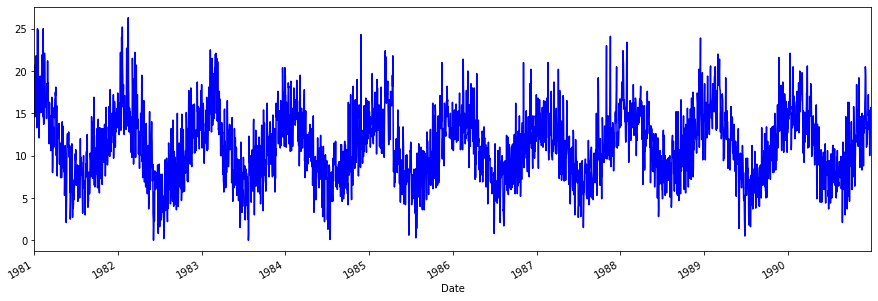

In [8]:
df.Temp.plot(figsize=(15, 5), color ="b")

# Dataset Splitting

In [9]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Dataset & Dataloader

In [10]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [11]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 5)
Note: last 7 data excluded

(N, S, F): (52, 14, 5)
Note: last 1 data excluded



# Arsitektur & Config

In [12]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.gru(x, hidden)
        x = self.fc(x)
        return x, hidden

In [13]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0
})

# Training Preparation -> MCOC

In [14]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/multivar")

# Training

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset,dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode =="test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 133.7922 | Test_cost  = 126.0363 | 




Epoch     2
Train_cost  = 107.1105 | Test_cost  = 97.8118 | 




Epoch     3
Train_cost  = 83.1634 | Test_cost  = 79.2757 | 




Epoch     4
Train_cost  = 68.5516 | Test_cost  = 67.7937 | 




Epoch     5
Train_cost  = 58.9769 | Test_cost  = 59.3091 | 




Epoch     6
Train_cost  = 51.5956 | Test_cost  = 52.3406 | 




Epoch     7
Train_cost  = 45.4511 | Test_cost  = 46.4007 | 




Epoch     8
Train_cost  = 40.2249 | Test_cost  = 41.3184 | 




Epoch     9
Train_cost  = 35.7951 | Test_cost  = 37.0079 | 




Epoch    10
Train_cost  = 32.0801 | Test_cost  = 33.3848 | 




Epoch    11
Train_cost  = 28.9936 | Test_cost  = 30.3598 | 




Epoch    12
Train_cost  = 26.4482 | Test_cost  = 27.8477 | 




Epoch    13
Train_cost  = 24.3626 | Test_cost  = 25.7713 | 




Epoch    14
Train_cost  = 22.6644 | Test_cost  = 24.0631 | 




Epoch    15
Train_cost  = 21.2906 | Test_cost  = 22.6641 | 




Epoch    16
Train_cost  = 20.1865 | Test_cost  = 21.5236 | 




Epoch    17
Train_cost  = 19.3053 | Test_cost  = 20.5983 | 




Epoch    18
Train_cost  = 18.6072 | Test_cost  = 19.8508 | 




Epoch    19
Train_cost  = 18.0582 | Test_cost  = 19.2495 | 




Epoch    20
Train_cost  = 17.6297 | Test_cost  = 18.7678 | 


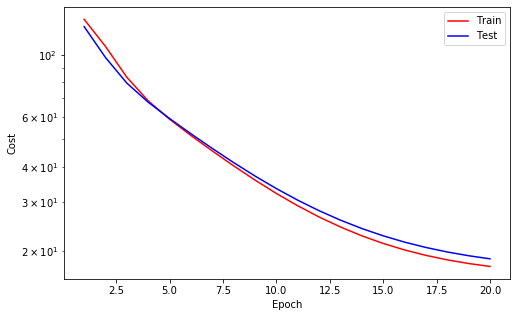



Epoch    21
Train_cost  = 17.2977 | Test_cost  = 18.3832 | 




Epoch    22
Train_cost  = 17.0424 | Test_cost  = 18.0770 | 




Epoch    23
Train_cost  = 16.8472 | Test_cost  = 17.8337 | 




Epoch    24
Train_cost  = 16.6990 | Test_cost  = 17.6405 | 




Epoch    25
Train_cost  = 16.5869 | Test_cost  = 17.4873 | 




Epoch    26
Train_cost  = 16.5024 | Test_cost  = 17.3656 | 




Epoch    27
Train_cost  = 16.4387 | Test_cost  = 17.2687 | 




Epoch    28
Train_cost  = 16.3906 | Test_cost  = 17.1915 | 




Epoch    29
Train_cost  = 16.3540 | Test_cost  = 17.1297 | 




Epoch    30
Train_cost  = 16.3258 | Test_cost  = 17.0799 | 




Epoch    31
Train_cost  = 16.3038 | Test_cost  = 17.0397 | 




Epoch    32
Train_cost  = 16.2862 | Test_cost  = 17.0069 | 




Epoch    33
Train_cost  = 16.2717 | Test_cost  = 16.9801 | 




Epoch    34
Train_cost  = 16.2594 | Test_cost  = 16.9579 | 




Epoch    35
Train_cost  = 16.2486 | Test_cost  = 16.9394 | 




Epoch    36
Train_cost  = 16.2387 | Test_cost  = 16.9239 | 




Epoch    37
Train_cost  = 16.2295 | Test_cost  = 16.9107 | 




Epoch    38
Train_cost  = 16.2206 | Test_cost  = 16.8994 | 




Epoch    39
Train_cost  = 16.2120 | Test_cost  = 16.8896 | 




Epoch    40
Train_cost  = 16.2033 | Test_cost  = 16.8810 | 


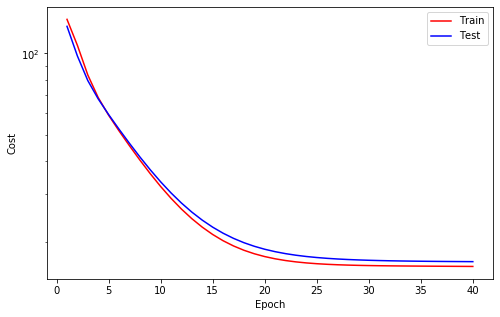



Epoch    41
Train_cost  = 16.1946 | Test_cost  = 16.8734 | 




Epoch    42
Train_cost  = 16.1858 | Test_cost  = 16.8666 | 




Epoch    43
Train_cost  = 16.1768 | Test_cost  = 16.8604 | 




Epoch    44
Train_cost  = 16.1675 | Test_cost  = 16.8548 | 




Epoch    45
Train_cost  = 16.1579 | Test_cost  = 16.8496 | 




Epoch    46
Train_cost  = 16.1481 | Test_cost  = 16.8447 | 




Epoch    47
Train_cost  = 16.1379 | Test_cost  = 16.8402 | 




Epoch    48
Train_cost  = 16.1274 | Test_cost  = 16.8358 | 




Epoch    49
Train_cost  = 16.1165 | Test_cost  = 16.8317 | 




Epoch    50
Train_cost  = 16.1050 | Test_cost  = 16.8277 | 




Epoch    51
Train_cost  = 16.0928 | Test_cost  = 16.8238 | 




Epoch    52
Train_cost  = 16.0795 | Test_cost  = 16.8201 | 




Epoch    53
Train_cost  = 16.0645 | Test_cost  = 16.8166 | 




Epoch    54
Train_cost  = 16.0469 | Test_cost  = 16.8134 | 




Epoch    55
Train_cost  = 16.0255 | Test_cost  = 16.8104 | 




Epoch    56
Train_cost  = 15.9974 | Test_cost  = 16.8072 | 




Epoch    57
Train_cost  = 15.9552 | Test_cost  = 16.8011 | 




Epoch    58
Train_cost  = 15.8699 | Test_cost  = 16.7715 | 




Epoch    59
Train_cost  = 15.6923 | Test_cost  = 16.5491 | 




Epoch    60
Train_cost  = 15.2701 | Test_cost  = 15.1098 | 


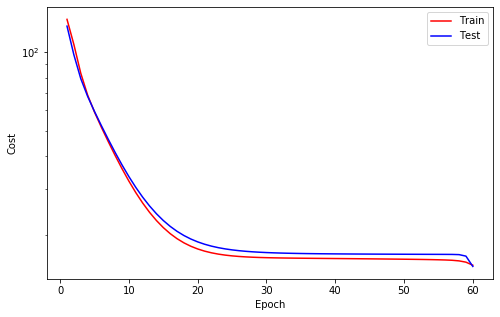



Epoch    61
Train_cost  = 13.7547 | Test_cost  = 13.9634 | 




Epoch    62
Train_cost  = 12.8001 | Test_cost  = 13.0253 | 




Epoch    63
Train_cost  = 11.7758 | Test_cost  = 11.8979 | 




Epoch    64
Train_cost  = 11.0336 | Test_cost  = 11.0863 | 




Epoch    65
Train_cost  = 10.4330 | Test_cost  = 10.4297 | 




Epoch    66
Train_cost  = 9.8937 | Test_cost  = 9.8962 | 




Epoch    67
Train_cost  = 9.5166 | Test_cost  = 9.4211 | 




Epoch    68
Train_cost  = 9.1997 | Test_cost  = 9.0368 | 




Epoch    69
Train_cost  = 8.8677 | Test_cost  = 8.7259 | 




Epoch    70
Train_cost  = 8.5908 | Test_cost  = 8.4313 | 




Epoch    71
Train_cost  = 8.3820 | Test_cost  = 8.1636 | 




Epoch    72
Train_cost  = 8.1813 | Test_cost  = 7.9327 | 




Epoch    73
Train_cost  = 7.9943 | Test_cost  = 7.7222 | 




Epoch    74
Train_cost  = 7.8433 | Test_cost  = 7.5302 | 




Epoch    75
Train_cost  = 7.7122 | Test_cost  = 7.3608 | 




Epoch    76
Train_cost  = 7.5882 | Test_cost  = 7.2086 | 




Epoch    77
Train_cost  = 7.4780 | Test_cost  = 7.0699 | 




Epoch    78
Train_cost  = 7.3834 | Test_cost  = 6.9467 | 




Epoch    79
Train_cost  = 7.2975 | Test_cost  = 6.8369 | 




Epoch    80
Train_cost  = 7.2175 | Test_cost  = 6.7371 | 


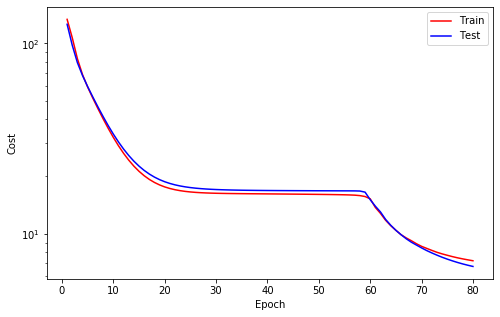



Epoch    81
Train_cost  = 7.1442 | Test_cost  = 6.6464 | 




Epoch    82
Train_cost  = 7.0770 | Test_cost  = 6.5632 | 




Epoch    83
Train_cost  = 7.0139 | Test_cost  = 6.4849 | 




Epoch    84
Train_cost  = 6.9540 | Test_cost  = 6.4104 | 




Epoch    85
Train_cost  = 6.8979 | Test_cost  = 6.3396 | 




Epoch    86
Train_cost  = 6.8457 | Test_cost  = 6.2725 | 




Epoch    87
Train_cost  = 6.7966 | Test_cost  = 6.2089 | 




Epoch    88
Train_cost  = 6.7503 | Test_cost  = 6.1487 | 




Epoch    89
Train_cost  = 6.7068 | Test_cost  = 6.0919 | 




Epoch    90
Train_cost  = 6.6661 | Test_cost  = 6.0385 | 




Epoch    91
Train_cost  = 6.6279 | Test_cost  = 5.9884 | 




Epoch    92
Train_cost  = 6.5921 | Test_cost  = 5.9414 | 




Epoch    93
Train_cost  = 6.5582 | Test_cost  = 5.8972 | 




Epoch    94
Train_cost  = 6.5261 | Test_cost  = 5.8554 | 




Epoch    95
Train_cost  = 6.4957 | Test_cost  = 5.8157 | 




Epoch    96
Train_cost  = 6.4666 | Test_cost  = 5.7784 | 




Epoch    97
Train_cost  = 6.4389 | Test_cost  = 5.7436 | 




Epoch    98
Train_cost  = 6.4123 | Test_cost  = 5.7111 | 




Epoch    99
Train_cost  = 6.3867 | Test_cost  = 5.6804 | 




Epoch   100
Train_cost  = 6.3620 | Test_cost  = 5.6513 | 


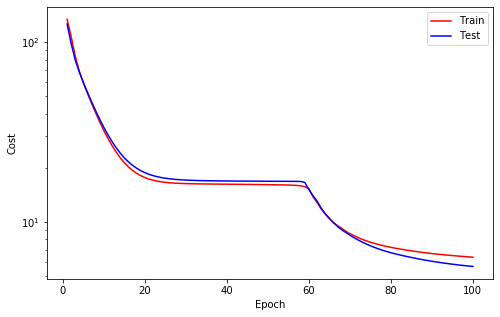



Epoch   101
Train_cost  = 6.3382 | Test_cost  = 5.6236 | 




Epoch   102
Train_cost  = 6.3154 | Test_cost  = 5.5975 | 




Epoch   103
Train_cost  = 6.2935 | Test_cost  = 5.5728 | 




Epoch   104
Train_cost  = 6.2726 | Test_cost  = 5.5496 | 




Epoch   105
Train_cost  = 6.2525 | Test_cost  = 5.5277 | 




Epoch   106
Train_cost  = 6.2331 | Test_cost  = 5.5068 | 




Epoch   107
Train_cost  = 6.2144 | Test_cost  = 5.4870 | 




Epoch   108
Train_cost  = 6.1965 | Test_cost  = 5.4681 | 




Epoch   109
Train_cost  = 6.1792 | Test_cost  = 5.4502 | 




Epoch   110
Train_cost  = 6.1625 | Test_cost  = 5.4332 | 




Epoch   111
Train_cost  = 6.1464 | Test_cost  = 5.4169 | 




Epoch   112
Train_cost  = 6.1308 | Test_cost  = 5.4014 | 




Epoch   113
Train_cost  = 6.1157 | Test_cost  = 5.3866 | 




Epoch   114
Train_cost  = 6.1011 | Test_cost  = 5.3726 | 




Epoch   115
Train_cost  = 6.0869 | Test_cost  = 5.3591 | 




Epoch   116
Train_cost  = 6.0731 | Test_cost  = 5.3462 | 




Epoch   117
Train_cost  = 6.0597 | Test_cost  = 5.3339 | 




Epoch   118
Train_cost  = 6.0467 | Test_cost  = 5.3222 | 




Epoch   119
Train_cost  = 6.0341 | Test_cost  = 5.3110 | 




Epoch   120
Train_cost  = 6.0219 | Test_cost  = 5.3003 | 


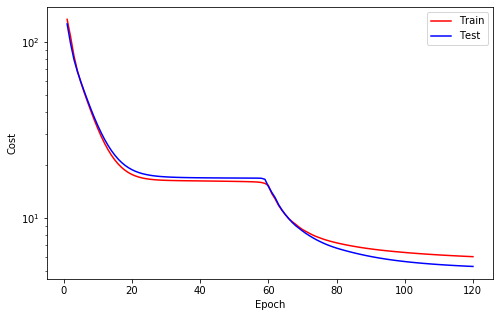



Epoch   121
Train_cost  = 6.0101 | Test_cost  = 5.2902 | 




Epoch   122
Train_cost  = 5.9987 | Test_cost  = 5.2806 | 




Epoch   123
Train_cost  = 5.9875 | Test_cost  = 5.2716 | 




Epoch   124
Train_cost  = 5.9766 | Test_cost  = 5.2630 | 




Epoch   125
Train_cost  = 5.9661 | Test_cost  = 5.2548 | 




Epoch   126
Train_cost  = 5.9558 | Test_cost  = 5.2471 | 




Epoch   127
Train_cost  = 5.9457 | Test_cost  = 5.2397 | 




Epoch   128
Train_cost  = 5.9359 | Test_cost  = 5.2326 | 




Epoch   129
Train_cost  = 5.9263 | Test_cost  = 5.2257 | 




Epoch   130
Train_cost  = 5.9169 | Test_cost  = 5.2192 | 




Epoch   131
Train_cost  = 5.9077 | Test_cost  = 5.2128 | 




Epoch   132
Train_cost  = 5.8986 | Test_cost  = 5.2066 | 




Epoch   133
Train_cost  = 5.8896 | Test_cost  = 5.2006 | 




Epoch   134
Train_cost  = 5.8808 | Test_cost  = 5.1948 | 




Epoch   135
Train_cost  = 5.8720 | Test_cost  = 5.1890 | 




Epoch   136
Train_cost  = 5.8634 | Test_cost  = 5.1835 | 




Epoch   137
Train_cost  = 5.8548 | Test_cost  = 5.1780 | 




Epoch   138
Train_cost  = 5.8463 | Test_cost  = 5.1727 | 




Epoch   139
Train_cost  = 5.8379 | Test_cost  = 5.1676 | 




Epoch   140
Train_cost  = 5.8296 | Test_cost  = 5.1626 | 


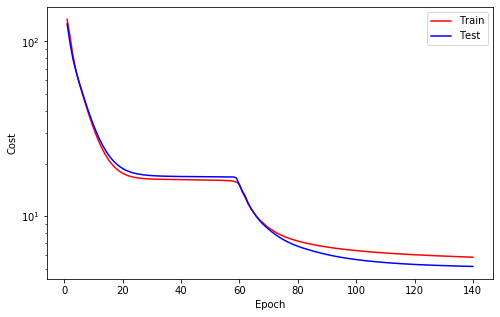



Epoch   141
Train_cost  = 5.8213 | Test_cost  = 5.1579 | 




Epoch   142
Train_cost  = 5.8131 | Test_cost  = 5.1533 | 




Epoch   143
Train_cost  = 5.8050 | Test_cost  = 5.1490 | 




Epoch   144
Train_cost  = 5.7970 | Test_cost  = 5.1450 | 




Epoch   145
Train_cost  = 5.7891 | Test_cost  = 5.1411 | 




Epoch   146
Train_cost  = 5.7813 | Test_cost  = 5.1375 | 




Epoch   147
Train_cost  = 5.7736 | Test_cost  = 5.1342 | 




Epoch   148
Train_cost  = 5.7660 | Test_cost  = 5.1311 | 




Epoch   149
Train_cost  = 5.7585 | Test_cost  = 5.1282 | 




Epoch   150
Train_cost  = 5.7511 | Test_cost  = 5.1255 | 




Epoch   151
Train_cost  = 5.7437 | Test_cost  = 5.1231 | 




Epoch   152
Train_cost  = 5.7364 | Test_cost  = 5.1208 | 




Epoch   153
Train_cost  = 5.7291 | Test_cost  = 5.1189 | 




Epoch   154
Train_cost  = 5.7218 | Test_cost  = 5.1172 | 




Epoch   155
Train_cost  = 5.7146 | Test_cost  = 5.1158 | 




Epoch   156
Train_cost  = 5.7074 | Test_cost  = 5.1149 | 




Epoch   157
Train_cost  = 5.7002 | Test_cost  = 5.1143 | 




Epoch   158
Train_cost  = 5.6930 | Test_cost  = 5.1141 | 




Epoch   159
Train_cost  = 5.6857 | Test_cost  = 5.1143 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1141




Epoch   160
Train_cost  = 5.6782 | Test_cost  = 5.1146 | 


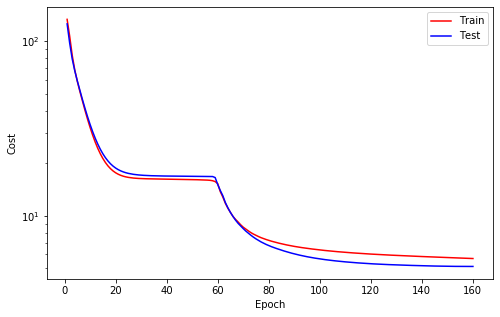

==> EarlyStop patience =  2 | Best test_cost: 5.1141




Epoch   161
Train_cost  = 5.6705 | Test_cost  = 5.1151 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1141




Epoch   162
Train_cost  = 5.6628 | Test_cost  = 5.1157 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1141




Epoch   163
Train_cost  = 5.6551 | Test_cost  = 5.1164 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1141
==> Execute Early Stopping at epoch: 163 | Best test_cost: 5.1141
==> Best model is saved at model/multivar


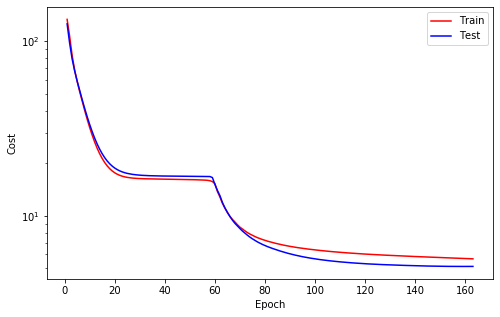

In [16]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost)
    
    #Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [13]:
from luwiji.rnn import illustration

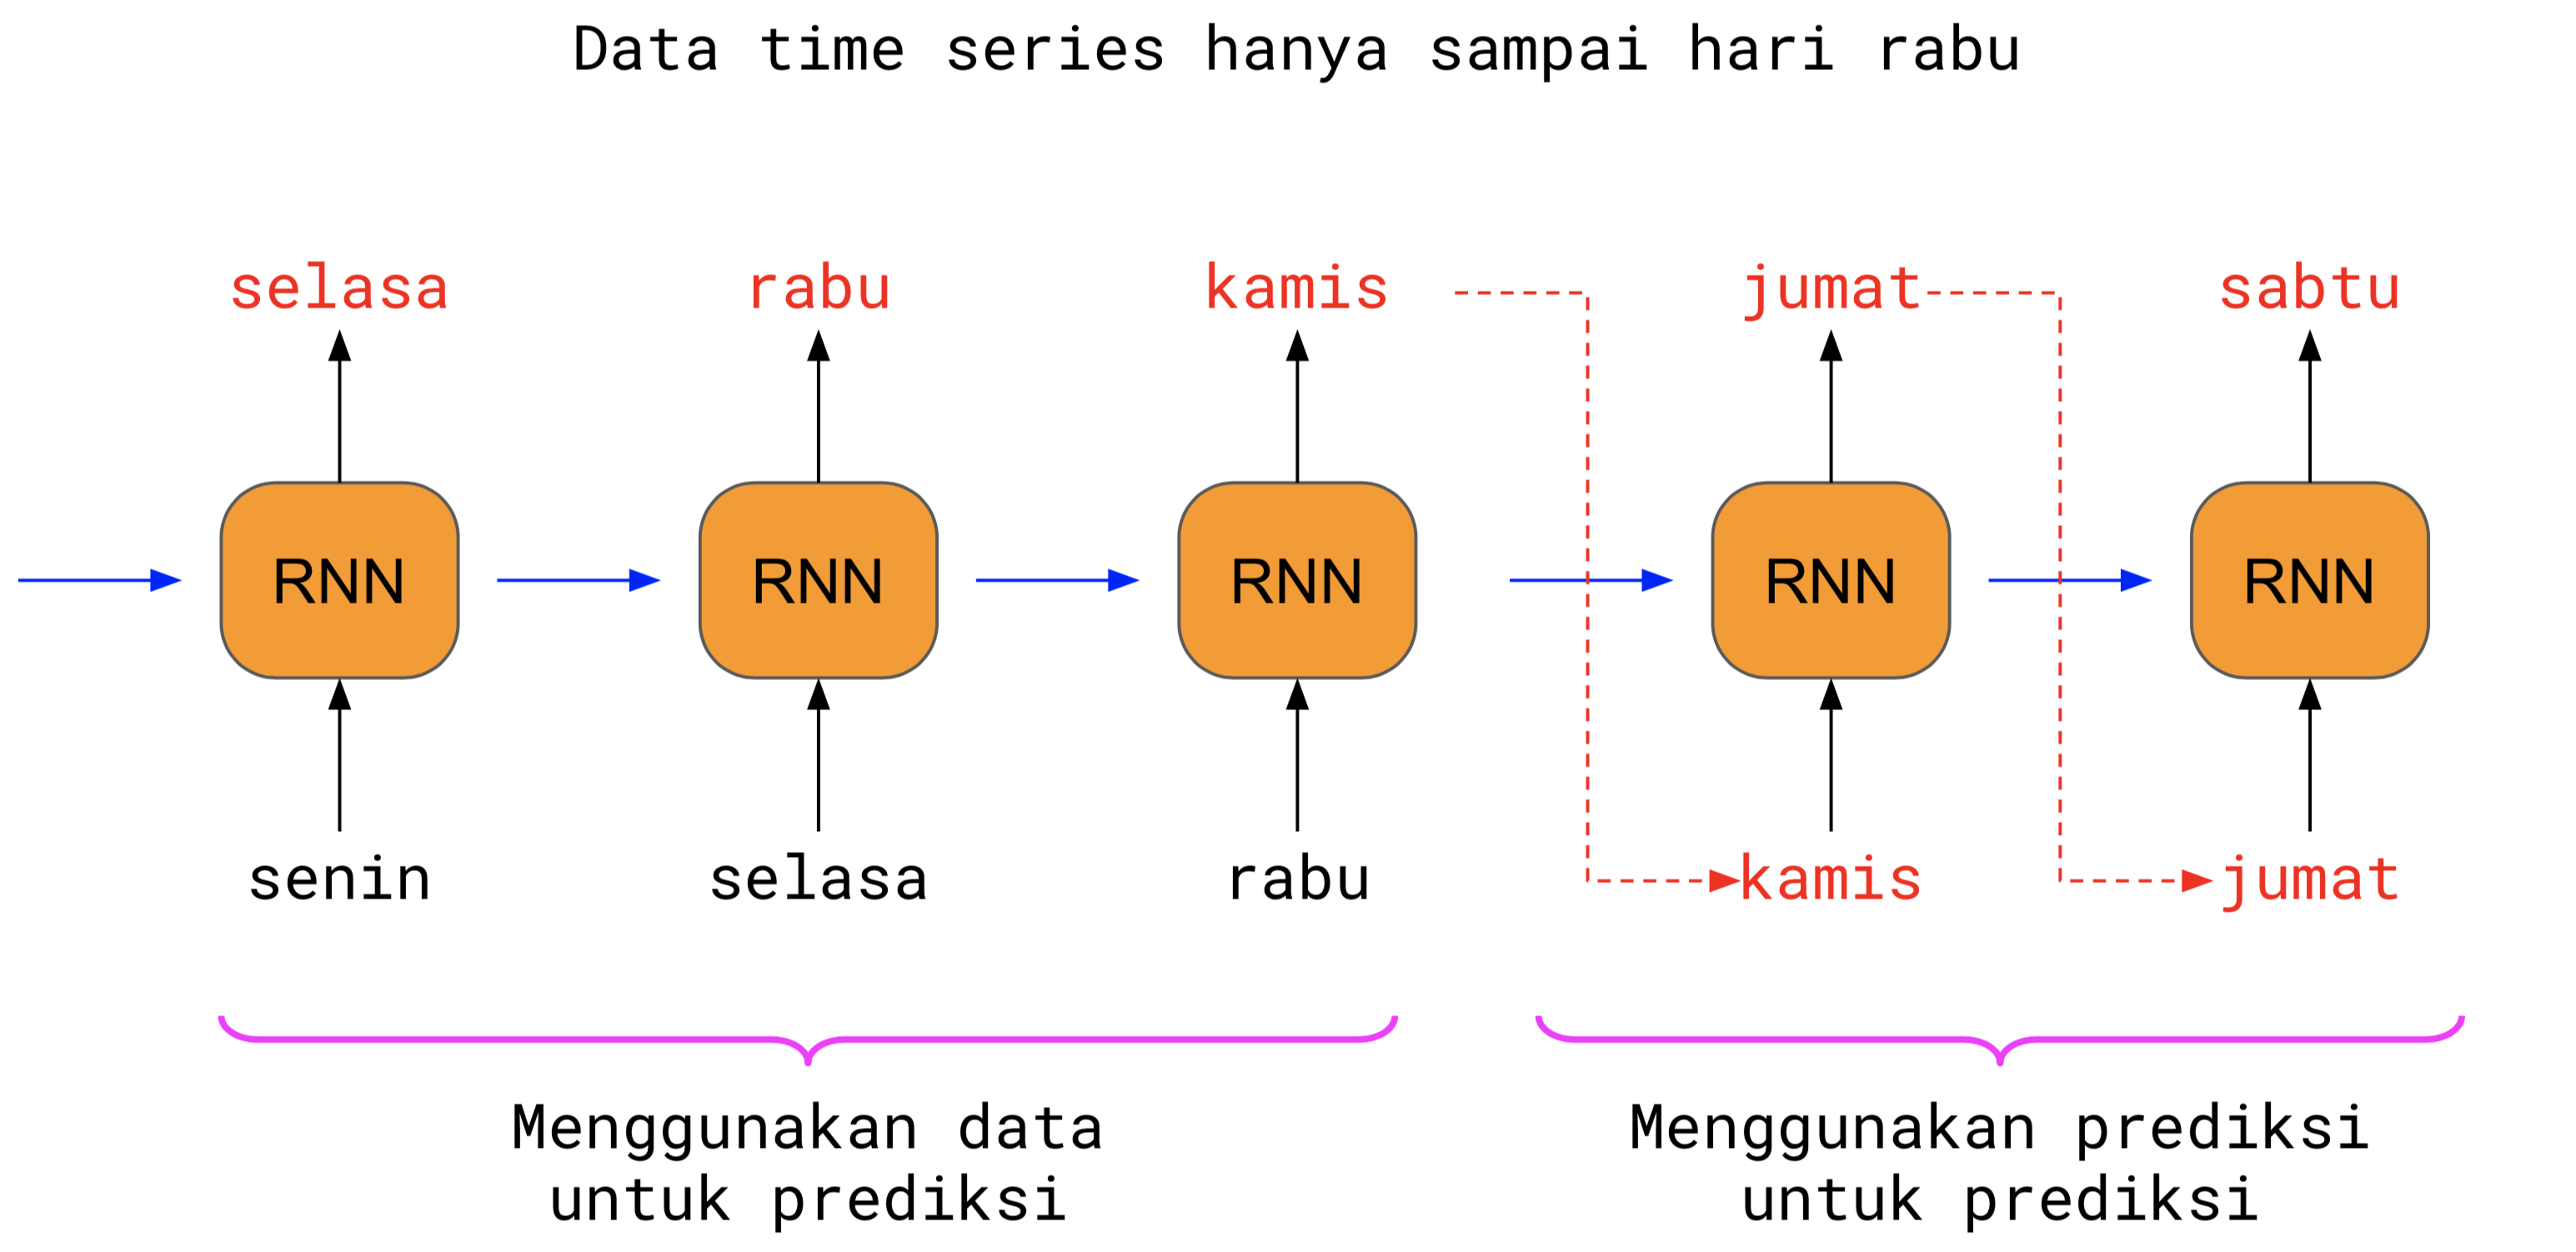

In [14]:
illustration.forecast

In [17]:
from utils import data4pred, pred4pred

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

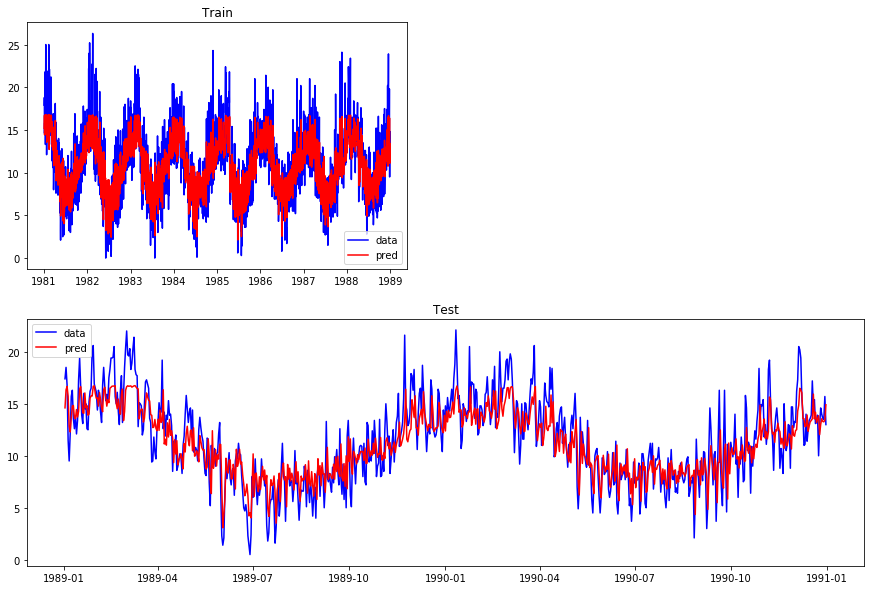

In [19]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(221)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

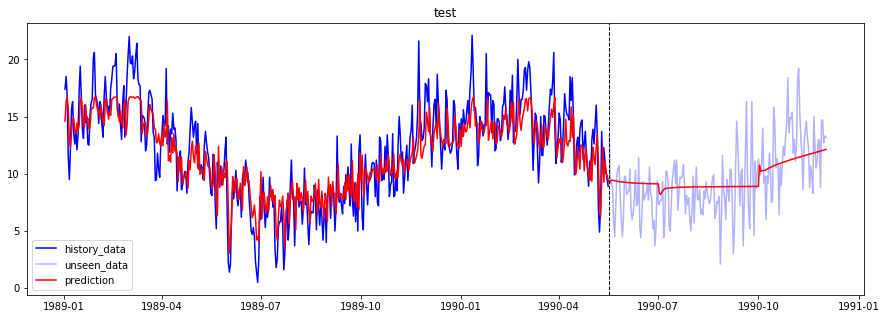

In [20]:
# Pred 4 Pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")

# More on RNN

In [21]:
from luwiji.rnn import illustration

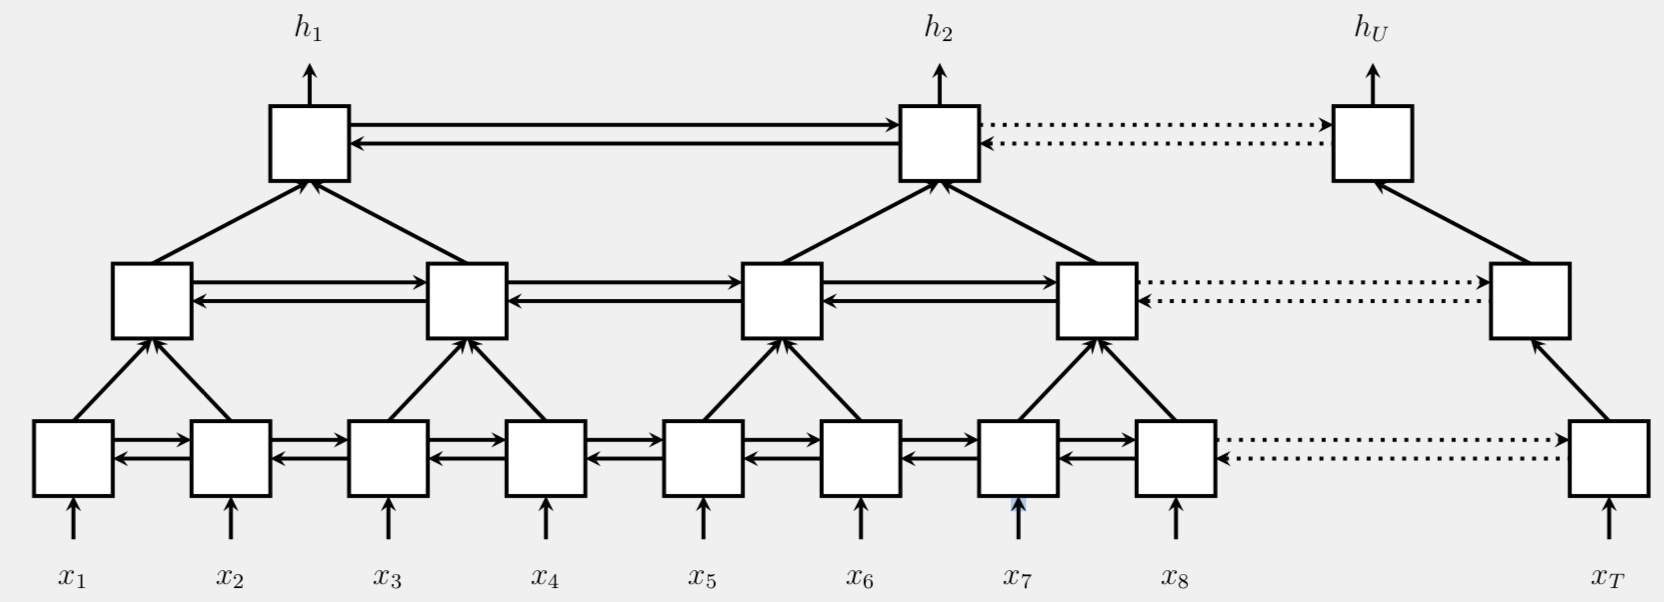

In [22]:
illustration.pyramid_blstm

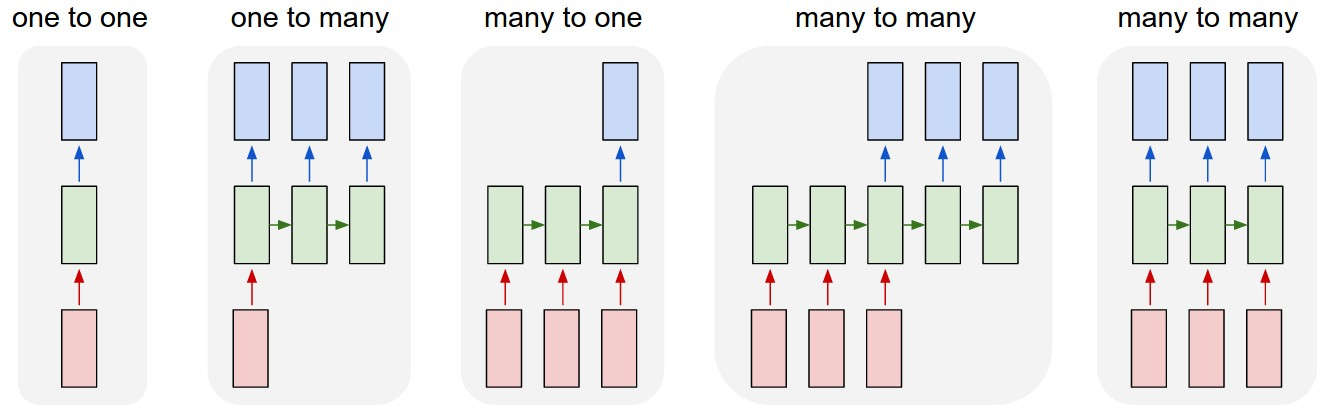

In [23]:
illustration.sequence_model

- one to one (fixed input and output):
    - Image classification
- one to many (fixed input and sequence output)
    - Image captioning
- many to many (sequence input and sequence output)
    - machine translation
- synced many to many (sequence input and sequence output)
    - frame level video classification
    
Please check this out<br>
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

RNN Midi Composer<br>
https://www.youtube.com/watch?v=0eTYs4n1LKg&t=2s